In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
%matplotlib inline
from datetime import datetime
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import tensorflow as tf

In [ ]:
plt.rcParams["figure.figsize"] = (15,10)

In [ ]:
root = '/content/drive/MyDrive/Semester 5 - Project REAPS/Documents/6 sem/Code/Data/'
df = pd.read_csv(root+'corrected/west_bengal.csv')
datelist = df['DATE']
date_samples = datelist.sample(10)
df.describe()

,AIR_TEMP(°C),WIND_SPEED(m/s),ATMO_PRESSURE(hpa),HUMIDITY(%),RAIN_FALL(mm)
count,37986.000000,37986.000000,37986.000000,37986.000000,37986.000000
mean,17.097033,0.748586,772.302168,48.501975,79.912604
std,12.560400,0.685272,386.545716,30.677135,100.071925
min,-40.000000,0.000000,0.000000,0.000000,0.000000
25%,3.833333,0.000000,928.400000,23.433333,6.333333
50%,21.650000,0.675000,956.512500,57.445000,19.250000
75%,27.250000,1.300000,973.242143,74.372917,150.500000
max,31.700000,2.200000,1007.550000,88.700000,979.000000


In [ ]:
cols = ['AIR_TEMP', 'WIND_SPEED', 'ATMO_PRESSURE', 'HUMIDITY', 'RAIN_FALL']
colname = ['AIR_TEMP(°C)', 'WIND_SPEED(m/s)', 'ATMO_PRESSURE(hpa)','HUMIDITY(%)', 'RAIN_FALL(mm)']
index = 4

In [ ]:
df = pd.read_csv(root+'corrected/west_bengal.csv')
df['DATE']= pd.to_datetime(df['DATE'])

## Data split
Split the data into training and test set 

In [ ]:
df = df.drop('DATE', 1)
training_set = df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


In [ ]:
sc = StandardScaler()
training_set_scaled = sc.fit_transform(training_set)
sc_predict = StandardScaler()
sc_predict.fit_transform(training_set.iloc[:, index:index+1])
# sc = MinMaxScaler(feature_range=(0, 1))
# training_set_scaled = sc.fit_transform(training_set)

array([[ 2.2642752 ],
       [ 2.24262382],
       [ 2.24262382],
       ...,
       [-0.79856219],
       [-0.79856219],
       [-0.79356572]])

In [ ]:
X_train = []
y_train = []

n_future = 1   
n_past = 60     

# 0 -> Air Temp
# 1 -> Wind speed
# 3 -> Atm Pressure
# 4 -> Humidity
# 5 -> Rainfall
for i in range(n_past, len(training_set_scaled) - n_future +1):
    X_train.append(training_set_scaled[i - n_past:i, 0:df.shape[1]])
    y_train.append(training_set_scaled[i + n_future - 1:i + n_future, index])

X_train, y_train = np.array(X_train), np.array(y_train)

print('X_train shape == {}.'.format(X_train.shape))
print('y_train shape == {}.'.format(y_train.shape))

X_train shape == (37926, 60, 5).
y_train shape == (37926, 1).


In [ ]:
model = Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(n_past, df.shape[1])))
model.add(LSTM(units=10, return_sequences=False))
model.add(Dropout(0.25))
model.add(Dense(units=1, activation='linear'))
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001,), loss='mean_squared_error')
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=5, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
mcp = ModelCheckpoint(filepath= root+'all_predictions_humidity_wb_week5_lstm_isro.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

tb = TensorBoard('logs')

history = model.fit(X_train, y_train, shuffle=True, epochs=20, callbacks=[es, rlr, mcp, tb], validation_split=0.2, verbose=1, batch_size=126)

Epoch 1/20
241/241 [==============================] - ETA: 0s - loss: 0.2539
Epoch 1: val_loss improved from inf to 0.08991, saving model to /content/drive/MyDrive/Semester 5 - Project REAPS/Documents/6 sem/Code/Data/all_predictions_humidity_wb_week5_lstm_isro.h5
241/241 [==============================] - 29s 104ms/step - loss: 0.2539 - val_loss: 0.0899 - lr: 0.0010
Epoch 2/20
241/241 [==============================] - ETA: 0s - loss: 0.1922
Epoch 2: val_loss improved from 0.08991 to 0.07534, saving model to /content/drive/MyDrive/Semester 5 - Project REAPS/Documents/6 sem/Code/Data/all_predictions_humidity_wb_week5_lstm_isro.h5
241/241 [==============================] - 22s 91ms/step - loss: 0.1922 - val_loss: 0.0753 - lr: 0.0010
Epoch 3/20
241/241 [==============================] - ETA: 0s - loss: 0.1745
Epoch 3: val_loss did not improve from 0.07534
241/241 [==============================] - 21s 89ms/step - loss: 0.1745 - val_loss: 0.0810 - lr: 0.0010
Epoch 4/20
241/241 [===========

In [ ]:
# model.save(root+'ISRO_MODE/'+cols[index]+'.h5')

In [ ]:
model = tf.keras.models.load_model(root+'ISRO_MODE/'+cols[index]+'.h5')

In [ ]:
predictions_train = model.predict(X_train[n_past:])

In [ ]:
y_pred_train = sc_predict.inverse_transform(predictions_train)
df['DATE'] = datelist

In [ ]:
PREDICTION_TRAIN = pd.DataFrame(y_pred_train, columns=[colname[index]]).set_index(pd.Series(datelist[2 * n_past + n_future -1:]))

In [ ]:
#Scaling up of data
for x in PREDICTION_TRAIN.columns:
  if(x == 'DATE'): 
    continue
  smin = df[x].min()
  smax = df[x].max()
  cmin = PREDICTION_TRAIN[x].min()
  cmax = PREDICTION_TRAIN[x].max()
  PREDICTION_TRAIN[x] = PREDICTION_TRAIN[x].apply(lambda x: smin + ((abs(x - cmin)/cmax)* (smax - smin + 1)))

(37866,)
(37866,)


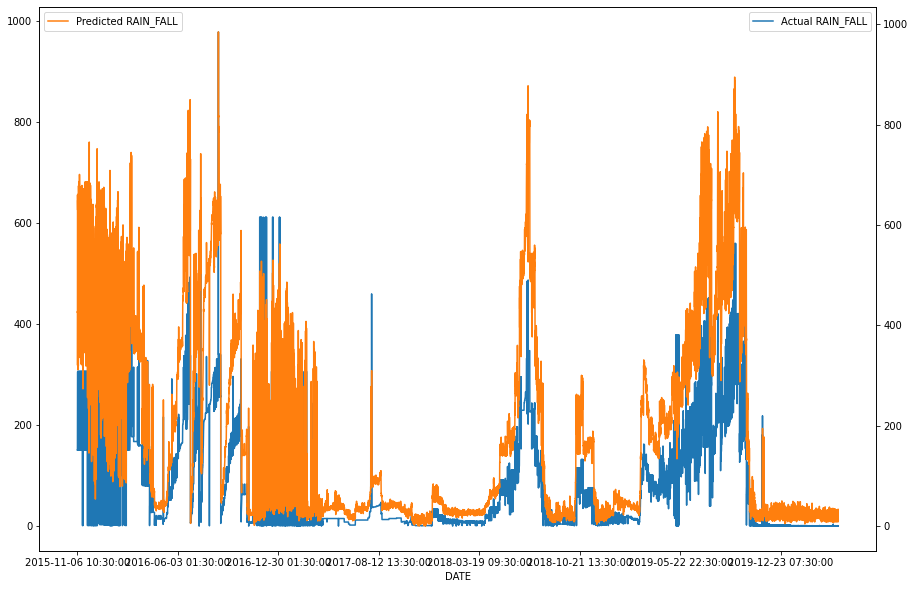

In [ ]:
print(df[colname[index]][2 * n_past + n_future -1:].shape)
print(PREDICTION_TRAIN[colname[index]].shape)
df.set_index('DATE')[colname[index]][2 * n_past + n_future -1:].plot()
plt.legend(['Actual '+cols[index]])
PREDICTION_TRAIN[colname[index]].plot(secondary_y=True)
plt.legend(['Predicted '+cols[index]],loc = 2)

In [ ]:
df_samples = pd.DataFrame(columns=['DATETIME', 'ACTUAL '+colname[index], 'PREDICTED '+colname[index], '% ERROR'])

In [ ]:
df_samples

,DATETIME,ACTUAL RAIN_FALL(mm),PREDICTED RAIN_FALL(mm),% ERROR


In [ ]:
print(date_samples)

12058    2017-03-21 11:30:00
6602     2016-08-03 19:30:00
17538    2017-11-24 19:30:00
23356    2018-08-01 18:30:00
22594    2018-06-30 23:30:00
10742    2017-01-25 11:30:00
33890    2019-10-27 13:30:00
4941     2016-05-26 14:30:00
9469     2016-12-02 11:30:00
25698    2018-11-14 23:30:00
Name: DATE, dtype: object


In [ ]:
for x in date_samples:
  predic = PREDICTION_TRAIN.loc[x][colname[index]]
  act = df.loc[df['DATE'] == x][colname[index]].tolist()[0]
  err = ((predic - act)/act)*100
  df_samples.loc[len(df_samples.index)] = [x, act, predic, err] 

In [ ]:
df_samples

,DATETIME,ACTUAL RAIN_FALL(mm),PREDICTED RAIN_FALL(mm),% ERROR
0,2017-03-21 11:30:00,8.500000,24.710692,190.714024
1,2016-08-03 19:30:00,226.000000,508.259128,124.893419
2,2017-11-24 19:30:00,1.000000,19.957392,1895.739248
3,2018-08-01 18:30:00,58.500000,120.296573,105.635167
4,2018-06-30 23:30:00,347.500000,784.510726,125.758482
5,2017-01-25 11:30:00,8.000000,40.590590,407.382369
6,2019-10-27 13:30:00,2.142857,24.868162,1060.514238
7,2016-05-26 14:30:00,136.000000,206.445583,51.798223
8,2016-12-02 11:30:00,6.333333,29.818846,370.823879
9,2018-11-14 23:30:00,76.000000,168.278998,121.419734


In [ ]:
# df_samples.to_csv(root + 'isro_data.csv', mode='a', index=False, header=True)